In this example, there is a Demon that monitors the amount of work that is being done on the system.
The Demon has some protocol in which it will interact with the system, but this protocol is reliant on whether the measured work exceeds some threshold $b=W_{\rm th}$ \emph{or} some threshold time is reached $T$.
The Demon will then interact with the system and stop the process and the system will be reset to its initial state.
Therefore the Demon will need to know the both probability distributions of the FHT at the threshold work $W_{\rm th}$ and the work distribution $P(W, T)$ at the threshold time $T$ to make informed betting strategy---for more details please read \cite{Manzano_thermodynamics_2021}.

In this example, we will set the temperature to zero such that $\bar{n}=0$.
One can then compute the power into the system by taking the time derivative of the Hamiltonian Eq.~(\ref{eq:sup_ham})
\begin{equation}
    \left<\frac{\partial H(t)}{\partial t}\right> = i\frac{\omega \Omega \hbar}{2}\left<e^{-i\omega t}\sigma_{+} - e^{i \omega t}\sigma_{-}\right>\,,
\end{equation}
which one can then transform into the interaction picture yields and integrate with respect to time to get the average work
\begin{equation}
    \langle W(t) \rangle = -\frac{\omega \Omega \hbar}{2}\int_{0}^{t}\langle \sigma_{y}(t')\rangle dt'\,.
\end{equation}
We can also define the stochastic work done over a single quantum trajectory where $\langle W(t) \rangle_{c}$ is computed using the stochastic evolution of $\langle \sigma_{y}(t) \rangle_{c}$. 
Furthermore the homodyne current can be written as 
\begin{equation}
    I(t) = \sqrt{\gamma}\langle \sigma_{y}\rangle_{c}dt + \xi(t)\,,
\end{equation}
where $xi(t) = dW/dt$ is the delta-correlated white noise. 
Therefore we can see that one can obtain an estimate of of the work $W(t)$ by integrating the homodyne current $N(t) {= \sqrt{\gamma}\int_{0}^{t} \langle \sigma_{y}(t')\rangle_{c}dt' + \int_{0}^{t}dW}$ yielding 
\begin{equation}
    W(t) = -\frac{\Omega \omega \hbar}{2 \sqrt{\gamma}}N(t)\,.
\end{equation}
Clearly, compute the statistics of the estimated work $W(t)$ by computing the statistics of $N(t)$. 
We therefore need to solve the the $N$-resolve density matrix for this the diffusion equation Eq.~(\ref{eq:ndiff_sup}), which we can do using finite difference methods 
\begin{equation}
    \frac{\partial \rho_{N}}{\partial t} = \frac{\rho_{N}(t+dt) - \rho_{N}(t)}{dt}\qquad {\rm and} \qquad 
    \frac{\partial \rho_{N}}{\partial N} = \frac{\rho_{N+\Delta N} - \rho_{N-\Delta N}}{2\Delta N}\qquad {\rm and} \qquad 
    \frac{\partial^{2} \rho_{N}}{\partial N^{2}} = \frac{\rho_{N+\Delta N} - 2\rho_{N} + \rho_{N-\Delta N}}{(\Delta N)^{2}}\,,
\end{equation}
where $N$ is now continuous and $\Delta N$ is a small real increment in $N$.
Written as a matrix equation, this becomes
\begin{equation}
    \left(
\begin{array}{c}
\rho_{N}(t+dt)\\
\rho_{N-\Delta N}(t+dt)\\
\vdots\\
\rho_{-N}(t+dt)
\end{array}
\right) =
\left(
\begin{array}{ccccc}
\mathbb{I}+dt\mathcal{L} - \frac{dt K_{D}}{\Delta N^{2}}  & \frac{dt \mathcal{H}}{2\Delta N} + \frac{dt K_{D}}{2\Delta N^{2}}, &0 & \dots & 0\\
-\frac{dt \mathcal{H}}{2\Delta N} + \frac{dt K_{D}}{2\Delta N^{2}}& \mathbb{I}+dt\mathcal{L} - \frac{dt K_{D}}{\Delta N^{2}} &\frac{dt \mathcal{H}}{2\Delta N} + \frac{dt K_{D}}{2\Delta N^{2}}&\dots & 0 \\
0 &-\frac{dt \mathcal{H}}{2\Delta N}+ \frac{dt K_{D}}{2\Delta N^{2}} & \ddots & \dots& 0\\
\vdots & \vdots & \vdots & \ddots & \vdots\\
0 & & \dots & &\mathbb{I}+dt\mathcal{L} - \frac{dt K_{D}}{\Delta N^{2}} 
\end{array}
\right)
\left(
\begin{array}{c}
\rho_{N}(t)\\
\rho_{N-\Delta N}(t)\\
\vdots\\
\rho_{-N}(t)
\end{array}
\right)
\end{equation}
To compute the work distribution at the threshold time $T$, we simply evolve this equation up to time $T$ then compute the trace of each of the elements $P(W, T) = P(N, T) = {\rm tr}[\rho_{N}(T)]$.

Now we want to introduce an absorbing boundary condition corresponding to the threshold work $W_{\rm th}$. This corresponds to the case that say when we hit some threshold value say $N_{\rm th}$ then probability is lost which we can again do by setting all values along this boundary equal to zero and terminating the array at this value
\begin{equation}
    \left(
\begin{array}{c}
\rho_{N_{\rm th}}(t+dt)\\
\rho_{N_{\rm th}-\Delta N}(t+dt)\\
\vdots\\
\rho_{-N}(t+dt)
\end{array}
\right) =
\left(
\begin{array}{ccccc}
0 & 0 &0 & \dots & 0\\
-\frac{dt \mathcal{H}}{2\Delta N} + \frac{dt K_{D}}{2\Delta N^{2}}& \mathbb{I}+dt\mathcal{L} - \frac{dt K_{D}}{\Delta N^{2}} &\frac{dt \mathcal{H}}{2\Delta N} + \frac{dt K_{D}}{2\Delta N^{2}}&\dots & 0 \\
0 &-\frac{dt \mathcal{H}}{2\Delta N}+ \frac{dt K_{D}}{2\Delta N^{2}} & \ddots & \dots& 0\\
\vdots & \vdots & \vdots & \ddots & \vdots\\
0 & & \dots & &\mathbb{I}+dt\mathcal{L} - \frac{dt K_{D}}{\Delta N^{2}} 
\end{array}
\right)
\left(
\begin{array}{c}
\rho_{N_{\rm th}}(t)\\
\rho_{N_{\rm th}-\Delta N}(t)\\
\vdots\\
\rho_{-N}(t)
\end{array}
\right)
\end{equation}
which can now be used to compute the FHT distribution. 

In [2]:
import numpy as np
from qutip import *
import matplotlib.pyplot as plt
from _funcs import *

import seaborn as sns
plt.rc('text', usetex=True)
sns.set()

def get_first_hit(array, x):
    # create a function that returs first hitting time of array >= x
    try: 
        return np.min(np.where(array>=x))
    except ValueError:
        return None


In [3]:
# Parameters
Gamma = 1
Omega = 1
Rabi = np.sqrt((Gamma)**2 + Omega**2)
dt = 0.0012
tf = 5*np.pi/(2*Omega)
t_cutoff = tf/5
t = np.arange(0, tf, dt)

# Define system operators
sp = sigmap()
sm = sigmam()
sx = sigmax()
sz = sigmaz()
sy = sigmay()
g = sm*sp
H = Omega*sx

# define dissipator and Hamiltonian
c_ops = [1j*np.sqrt(Gamma) * sm]    

# steadystate
rho0 = fock(2, 0)
rhoss = steadystate(H, c_ops)

unconditional_result = mesolve(H, rho0, t, c_ops=c_ops, e_ops=[sy, sz, g])
ez_un = unconditional_result.expect[1]
ey_un = unconditional_result.expect[0]
g_un = unconditional_result.expect[2]
N_cutoff = 1


In [4]:
# number of chargers to truncate at 
Nm = 20
dN = 0.06
N = np.arange(-10, Nm, dN)

# ------ Solve n-resolved method with absorbing boundary conditions ------ #
diff = DiffusiveEvolutionPntAbsorb(H, c_ops, 1, t, N, N_cutoff, kind='single')
diff_T = DiffusiveEvolutionPnt(H, c_ops, 1, t, N)
Pn_vec = diff.solve(rho0)
Pn_vec_T = diff_T.solve(rho0)

Converting initial state to vector form


Evolution Superoperator: 100%|██████████| 6544/6544 [00:10<00:00, 649.86it/s]


Converting initial state to vector form


Evolution Superoperator: 100%|██████████| 6544/6544 [00:50<00:00, 128.82it/s]


In [5]:
# Compute survival probability from analytic solution
P0 = np.sum(Pn_vec, axis=0)
dGt = -np.gradient(P0, dt)

# Compute mean and variance of distribution
Et = np.sum(dGt * t)*dt
Var = np.sum(dGt * t**2)*dt - Et**2

np.sum(dGt)*dt

0.8770806675198743

In [6]:
ntraj = 2000
result = ssesolve(H, rho0, t, sc_ops=c_ops, e_ops=[sy, g], store_measurement=True, ntraj=ntraj)

10.0%. Run time:  15.47s. Est. time left: 00:00:02:19
20.0%. Run time:  30.72s. Est. time left: 00:00:02:02
30.0%. Run time:  46.61s. Est. time left: 00:00:01:48
40.0%. Run time:  62.05s. Est. time left: 00:00:01:33
50.0%. Run time:  77.34s. Est. time left: 00:00:01:17
60.0%. Run time:  92.51s. Est. time left: 00:00:01:01
70.0%. Run time: 107.73s. Est. time left: 00:00:00:46
80.0%. Run time: 122.87s. Est. time left: 00:00:00:30
90.0%. Run time: 138.03s. Est. time left: 00:00:00:15
Total run time: 153.19s


In [7]:
# get measurement results

Iy = np.real(np.array(result.measurement).reshape(ntraj, len(t)))

meas = np.real(result.measurement[0].T)[0]
meas_average = np.mean(result.measurement, axis=0).T[0]
ey = np.real(result.expect[0])
ez = np.real(result.expect[1])

int_meas = dt*np.cumsum(meas)
W = -Omega*dt*np.cumsum(Iy, axis=1)/np.sqrt(Gamma)
int_ey = dt*np.cumsum(ey)

# get first hitting time of measurement
indx = get_first_hit(int_meas, N_cutoff)
if indx is None:
    first_hit = tf
else:
    first_hit = t[indx]

# Get first hitting times
inds = np.array([get_first_hit(mi, N_cutoff) for mi in -W])
inds = inds[inds != None]

# Get first hitting times
hitting_times = t[list(inds)]

In [8]:
idx_W = np.argmin(np.abs(t - tf/5))

# Integrate first hitting time distribution to t_cutoff
PT = np.sum(dGt[t<t_cutoff])*dt
N_min = np.argmin(np.abs(N+N_cutoff))
Wbar = -np.sum(N[N_min:]*Pn_vec_T[N_min:, idx_W])
W_T = N_cutoff * PT +(1-PT) * Wbar

# N_th = PT + 

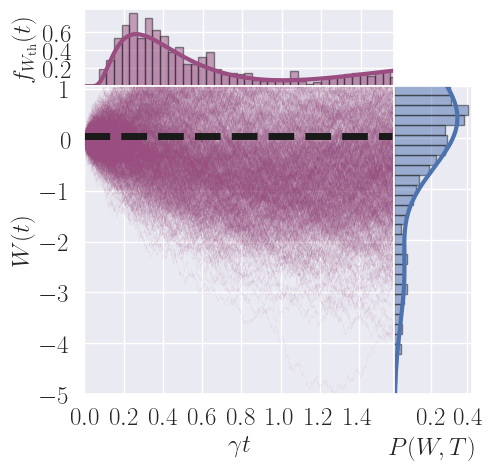

In [11]:
fig = plt.figure(figsize=(5, 5))
gs = fig.add_gridspec(5, 5)

color = [0.6, 0.3, 0.5]
fs = 18

ax1 = fig.add_subplot(gs[0, :4])
ax1.plot(t, dGt, color=color, linewidth=3)
ax1.fill_between(t, dGt, color=color, alpha=0.2)
ax1.hist(hitting_times, bins=200, color=color, alpha=0.5, density=True, edgecolor='k')

plt.xticks(np.arange(0, tf, 0.2), [])
plt.xlim(0, t_cutoff)
plt.yticks(np.arange(0.2, 0.7, 0.2), fontsize=fs)
plt.ylabel(r'$f_{W_{\rm th}}(t)$', fontsize=fs)

ax2 = fig.add_subplot(gs[1:5, :4])
ax2.plot(t, -W[:1000].T, color=color, linewidth=0.05, alpha=0.5)
# plt.vlines(t_cutoff, -5, N_cutoff, color='b', linewidth=5, linestyle='--')
# plt.hlines(N_cutoff, 0, t_cutoff, color=color, linewidth=5, linestyle='--')
plt.hlines(W_T, 0, t_cutoff, color='k', linewidth=5, linestyle='--')

plt.ylim(-5, N_cutoff+0.05)
plt.yticks(np.arange(-5, N_cutoff+1, 1), fontsize=fs)
plt.xticks(np.arange(0, t_cutoff, 0.2), fontsize=fs)
plt.xlim(0, t_cutoff+0.01)
plt.ylabel(r'$W(t)$', fontsize=fs)
plt.xlabel(r'$\gamma t$', fontsize=fs)

ax3 = fig.add_subplot(gs[1:, 4])
ax3.plot(Pn_vec_T[:, idx_W]/dN, -N, color='b', linewidth=3)
ax3.hist(W[:, idx_W], bins=50, orientation='horizontal', color='b', alpha=0.5, density=True, edgecolor='k')
plt.yticks(np.arange(-5, N_cutoff+1, 1),[])
plt.ylim(-5, N_cutoff)
plt.xticks(np.arange(0.2, 0.5, 0.2), fontsize=fs)

plt.xlabel(r'$P(W, T)$', fontsize=fs)
plt.subplots_adjust(wspace=0, hspace=0)

plt.show()

fig.savefig('Figures/Gambling_demon_mean.png', bbox_inches='tight', dpi=200)


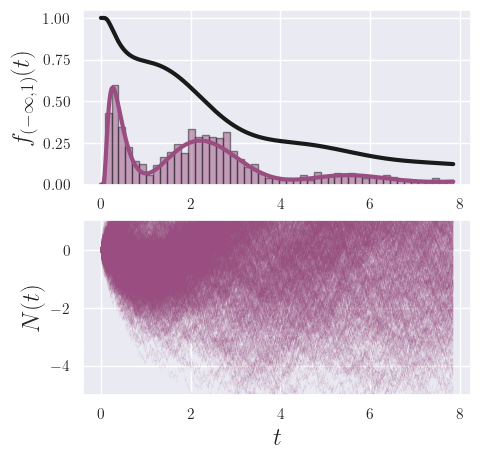

In [27]:
fig = plt.figure(figsize=(5, 5))

plt.subplot(2, 1, 1)
plt.plot(t, dGt, color=color, linewidth=3)
plt.plot(t, P0, color='k', linewidth=3)
plt.hist(hitting_times, bins=50, color=color, alpha=0.5, density=True, edgecolor='k')
plt.ylabel(r'$f_{(-\infty, 1)}(t)$', fontsize=fs)

plt.subplot(2, 1, 2)
plt.plot(t, -W[:1000].T, color=color, linewidth=0.02, alpha=1)

plt.ylim(-5, N_cutoff+0.05)

plt.ylabel(r'$N(t)$', fontsize=fs)
plt.xlabel(r'$t$', fontsize=fs)


plt.show()